# Multi-class Classification

This notebook will go through a machine learning implementation of Multi-class Classification using multivariate logistic regression.

## Setup

As per usual, the first thing we need to do is load some data, and visualise it.
This dataset is in a native matlab format however, so we have to use a module from *scipy* to load the data

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

data = loadmat('data/ex3data1.mat')

This dataset is a series of handwritten digits, an example of some of the digits can be seen below. We are going to train a logistic regression in a 'one vs. all' approach in order to classify the images.

There are 5000 training examples, where each training example is a 20 x 20 array of grayscale pixels. We can then *unroll* the 2D array of pixels into a 400-dimensional vector, thereby making our $X$ matrix have a size (5000, 400). Additionally we have a 5000-dimensional vector $Y$ representing the labels of each training dataset.

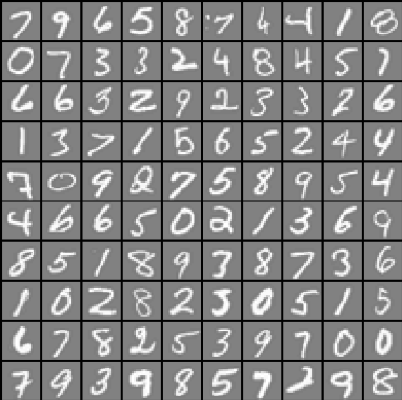

In [ ]:
data

## Model
Now we need to train 10 different logistic regression models, luckily we have previously covered the mathematical definition of logistic regression, as well as the vectorized regularized implentation in python. Below is the implementation of the cost function and gradient.

In [50]:
def sigmoid(z):
   return (1 / (1 + np.exp(-z)))

def cost(theta, X, Y, lmbda):
    
    # Convert X and Y into matrix data type
    if type(X) == np.ndarray:
        X = np.matrix(X)
    if type(Y) == np.ndarray:
        Y = np.matrix(Y)
    # Convert theta into matrix data type
    if type(theta) == np.ndarray:
        theta = np.matrix(theta)
        
    # Get hypothesis
    h = sigmoid(X*theta.T)
    m,n = X.shape
    # Get regularized term
    reg = (lmbda / (2*m)) * (np.sum(np.square(theta[:,1:n])))
    # Calculate cost
    J = (1/m)*((-Y.T * np.log(h)) - ((1-Y).T * np.log(1-h))) + reg
    
    return J.item()
    
def gradient(theta, X, Y, lmbda):
    # Convert theta from numpy.ndarray to matrix
    theta = np.matrix(theta)
    # Get hypothesis
    h = sigmoid(X*theta.T)
    m,n = X.shape
    # Get regularized term
    reg = (lmbda / m) * (theta.T)
    # Calculate gradient
    grad = (1/m)* X.T*(h-Y) + reg
    # Remove regularization from theta 0
    grad[0,0] = grad[0,0] - reg[0,0]

    return grad

As a logistic regression model only has two possible outputs, in order to deal with a higher number of classes we need to use *one vs. all*, that is training $K$ different logistic regression models, each capapable of identifying one of the $K$ classes.

To do this we will combine all of the $\theta$ matrices for the $K$ classifiers into one matrix $\Theta$ where each row represents the weights of a logistic regression.

In [51]:
from scipy.optimize import minimize

def one_vs_all(X, Y, num_labels, lmbda):
    # First let's insert a column of 0s into X
    X_h = np.insert(X, 0, values=np.ones(len(X)), axis=1)
    m,n = X_h.shape
    
    # Initialize Theta matrix
    all_theta = np.zeros((num_labels, n))
    # matlab arrays start at 1, therefore we must account for this
    for i in range(1, num_labels+1):
        # Initialize theta
        theta = np.zeros(n)
        # Get labels for ith class
        y = np.array([1 if label == i else 0 for label in Y])
        # Reshape array to vector format
        y = np.reshape(y, (m,1))
        # Find minimum theta
        print('Calculating theta for label: {}'.format(i))
        fmin = minimize(fun=cost, x0=theta, args=(X_h, y, lmbda), method='TNC', jac=gradient)
        # Add this to Theta matrix
        all_theta[i-1,:] = fmin.x
    return all_theta

Theta = one_vs_all(data['X'], data['y'], 10, 1)

Calculating theta for label: 1
Calculating theta for label: 2
Calculating theta for label: 3
Calculating theta for label: 4
Calculating theta for label: 5
Calculating theta for label: 6
Calculating theta for label: 7
Calculating theta for label: 8
Calculating theta for label: 9
Calculating theta for label: 10


In [52]:
print(Theta)

[[-2.38318374e+00  0.00000000e+00  0.00000000e+00 ...  1.30442679e-03
  -7.56104463e-10  0.00000000e+00]
 [-3.18410035e+00  0.00000000e+00  0.00000000e+00 ...  4.46067536e-03
  -5.08564614e-04  0.00000000e+00]
 [-4.79696826e+00  0.00000000e+00  0.00000000e+00 ... -2.86879026e-05
  -2.47223922e-07  0.00000000e+00]
 ...
 [-7.98492546e+00  0.00000000e+00  0.00000000e+00 ... -8.93653391e-05
   7.21303710e-06  0.00000000e+00]
 [-4.57046976e+00  0.00000000e+00  0.00000000e+00 ... -1.33690730e-03
   9.99668724e-05  0.00000000e+00]
 [-5.40237477e+00  0.00000000e+00  0.00000000e+00 ... -1.16778986e-04
   7.99100475e-06  0.00000000e+00]]


Now let's use $\Theta$ to predict the digits in our dataset, and so how accurate our model is!

In [63]:
def predict_all(X, Theta):
    # Insert 0s column in X
    X_h = np.insert(X, 0, values=np.ones(len(X)), axis=1)
    m,n = X_h.shape
    # Get number of labels from theta
    num_labels = Theta.shape[0]

    # convert to matrices
    X_h = np.matrix(X_h)
    Theta = np.matrix(Theta)
    
    # compute the probability for each class on each training instance
    h = sigmoid(X_h*Theta.T)

    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)
    
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax += 1
    
    return h_argmax

In [64]:
y_pred = predict_all(data['X'], Theta)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, data['y'])]
acc = float(sum(correct)) / float(len(correct))
print('accuracy = {0:.2f}%'.format(acc * 100))

accuracy = 94.46%


almost 95% classification, not bad!